## Semantic segmentation
Задача сегментации медицинских снимков, решаемая полносвёрточными сетями:
* SegNet
* Unet-maxpooling
* Unet-transpose convolution

<br>с метриками:
* binary cross entropy
* dice-loss
* focal-loss
* boundary-loss
* tversky-loss

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-08-19 14:17:36--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-08-19 14:17:36--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2d07f27078a43ea71aa164287b.dl.dropboxusercontent.com/cd/0/inline/CCGGAIe4P8ds6hvMjEhPj-hw8fY1vUdkHVdK_qdeR1OxBygBcHtZvoQVGBV3iFoXmYUSaVnbjjx6VNLAD5ttSpjhQ4LGSe9lQoclAyQYBdm3W_ChIuTnjFbwtt5oR4qoPC8/file# [following]
--2023-08-19 14:17:36--  https://uc2d07f27078a43ea71aa164287b.dl.dropboxusercontent.com/cd/0/inline/CCGGAIe4P8ds6hvMjEhPj-hw8fY1vUdkHVdK_qdeR1OxBygBcHtZvoQVGBV3iFoXmYUSaVnbjjx6VNLAD5ttSpjhQ4LGSe9lQoclAyQYBdm3W_ChIuTnj

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
import numpy as np
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.

In [5]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(1, 7):
    for pos, pic in zip((i, i+6), (X[i], Y[i])):
        plt.subplot(2, 6, pos)
        plt.axis("off")
        plt.imshow(pic)

plt.show();

Разделим наши 200 картинок на 100/50/50 для обучения, валидации и теста соответственно

In [7]:
idx = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(idx, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


### Dataloaders

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 25

data_tr  = DataLoader(list(zip(np.rollaxis(X[tr],  3, 1), Y[tr, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
data_ts  = DataLoader(list(zip(np.rollaxis(X[ts],  3, 1), Y[ts, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
print('successful')

successful


In [9]:
import torch

is_cuda = torch.cuda.is_available()
#device = 'cpu'
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


![image.png](attachment:0cea083b-0d70-4f30-925b-e1b4c47bcadd.png)
Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional encoder-decoder architecture for image segmentation](http://https://arxiv.org/pdf/1511.00561.pdf)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

#### В статье написано, что для енкодера модели взяты первые 13 слоёв из архитектуры Vgg16. Посмотрим на эту сеть

In [11]:
from torchvision import models
vgg = models.vgg16()
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
# Поскольку сеть из многих повторяющихся блоков, сделаем такой блок классом

class OneUnit(nn.Module):
    """
    Блок Conv2D + BatchNorm + Relu
    param ker_size: размер стороны квадратного ядра свёртки, int
    param stride_size: отступ страйда, int
    param pad_size: отступ паддинга, int
    """
    def __init__(self, in_channels, out_channels, ker_size, stride_size, pad_size):
        super(OneUnit, self).__init__()
        self.unit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ker_size,
                      padding=pad_size, stride=stride_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.unit(x)

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0)
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc0, idx0 = self.pool0(self.enc_conv0(inp))
        enc1, idx1 = self.pool1(self.enc_conv1(enc0))
        enc2, idx2 = self.pool2(self.enc_conv2(enc1))
        enc3, idx3 = self.pool3(self.enc_conv3(enc2))

        # bottleneck
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(self.upsample3(neck, idx3))
        dec2 = self.dec_conv2(self.upsample2(dec3, idx2))
        dec1 = self.dec_conv1(self.upsample1(dec2, idx1))
        dec0 = self.dec_conv0(self.upsample0(dec1, idx0))

        # no activation
        return dec0

print('NAME:\tSegNet\nPARAMS:\t', sum(len(p) for p in SegNet().parameters() if p.requires_grad))

NAME:	SegNet
PARAMS:	 27652


## Метрика

Используем следующую метрику для оценки качества:

$$\mathrm{IoU} = \frac{\text {target } \cap \text { prediction }}{\text {target } \cup\text{prediction }}$$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.
Для примера посмотрим на истину (слева) и предсказание (справа):
<br>
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)
<br> Тогда пересечение и объединение будет выглядеть так:
<br>
![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, treshold=0.5, SMOOTH=1e-8):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()             # BATCH x 1 x H x W => BATCH x H x W
    labels  = labels.squeeze(1).byte()

    inter = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (inter + SMOOTH) / (union + SMOOTH)                       # We avoid 0/0
    # [0, 1] => [-1, 1]
    return torch.clamp(20 * (iou - treshold), 0, 10).ceil() / 10

print('successful')

successful


## Функция потерь
Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), которая преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта лосс-функция страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss_test(y_real, y_pred):
    return nn.BCEWithLogitsLoss()(y_real, y_pred)

def bce_loss(y_pred, y_real):
    loss = (1 - y_real) * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

# протестируем функцию, сравнив с той, что из коробки
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

bce_loss_test(y_r, y_p), bce_loss(y_r, y_p)       # совпадают

(tensor(0.8099), tensor(0.8099))

## Тренировка

In [15]:
def score_model(model, metric, data, treshold=0.5):
    model.eval()               # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred > treshold, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores / len(data)

print('successful')

successful


In [50]:
from IPython.display import clear_output
import gc
from scipy.ndimage import distance_transform_edt

def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch, boundary=False, mix=False, loss2=None, alpha=0):
    if is_cuda:
        torch.cuda.empty_cache()
    gc.collect()

    best_model_wts = model.state_dict() #добавлено для оптимизации
    best_acc = 0.0

    losses = {'train': [], 'valid': []}
    scores = []
    for epoch in range(1, epochs+1):
        tic = time()
        print(f'* Epoch:\t{epoch}/{epochs}')
        avg_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_batch_cpu = Y_batch.to('cpu')

            # Вычисление карты расстояний
            dist_map = torch.tensor(distance_transform_edt(Y_batch_cpu))

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            probs = torch.softmax(Y_pred, dim=1).to('cpu')
            if (boundary == True) & (mix==False):
                loss = loss_fn(probs, dist_map) # forward-pass
            elif (boundary == True) & (mix==True):
                loss = alpha * loss_fn(probs, dist_map) + ((1 - alpha) * loss2(Y_pred, Y_batch))
            else:
                loss = loss_fn(Y_pred, Y_batch)


            loss.backward()                   # backward-pass
            opt.step()                        # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(f'train_loss:\t{avg_loss}')
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval()
        avg_loss = 0
        for X_val, Y_val in data_val:   # testing mode
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()   # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)                     # forward-pass
                avg_loss += loss / len(data_val)
        losses['valid'].append(avg_loss.item())


        current_acc = score_model(model, metric, data_val)
        scores.append(current_acc)
        if current_acc > best_acc:
            best_acc = current_acc
            best_model_wts = model.state_dict()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()

    print('Best val Acc: {:4f}'.format(best_acc))
    #model.load_state_dict(best_model_wts)

    return [losses, scores]

print('successful')

successful


### SegNet + BCEentropy

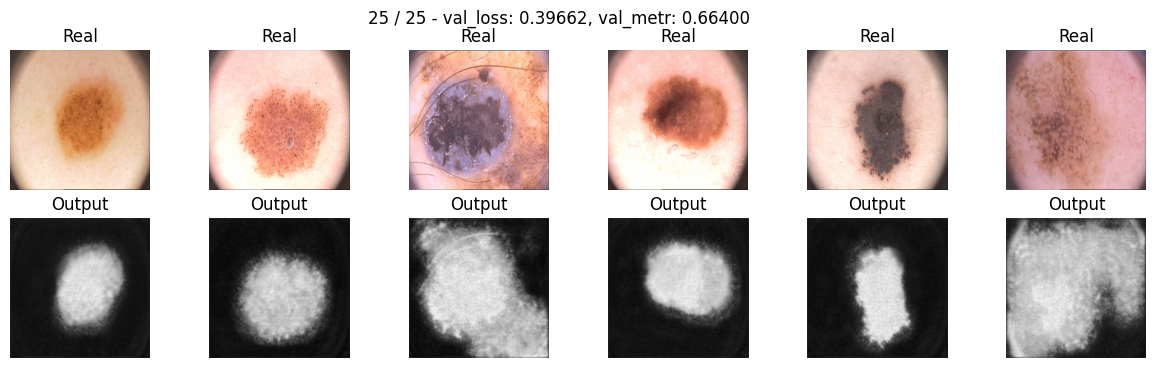

Best val Acc: 0.678000
VALID:	 0.6639999747276306 
TEST:	 0.527999997138977


In [28]:
import torch.optim as optim

MAX_EPOCHS = 25

model_bce = SegNet().to(device)
opt = optim.Adam(model_bce.parameters())
res_bce, acc_bce = train(model_bce, opt, bce_loss, MAX_EPOCHS, data_tr, data_val)

print('VALID:\t', score_model(model_bce, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_bce, iou_pytorch, data_ts))

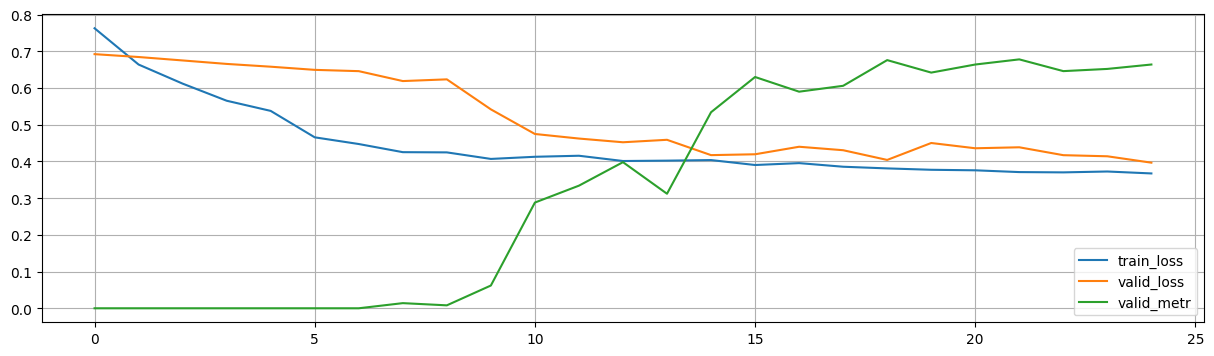

In [29]:
res, acc = res_bce, acc_bce
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

### Metrics: Dice coefficient
Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:
$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$
Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:
$$\mathcal L_D(X,Y) = 1-\frac{1}{256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$
Не забудьте подумать о численной нестабильности, возникающей в математической формуле.

In [30]:
# если 0 <= X, Y < 256, следует разделить на 256
# если 0 <= X, Y < 1, делить не нужно

def dice_loss(y_real, y_pred, from_logits=True):
    if from_logits:
        y_pred = torch.sigmoid(y_pred)
    num = torch.sum(y_real * y_pred)
    den = torch.sum(y_real + y_pred)
    res = 2 * num / (den or 1)             # если den == 0
    return 1 - res # / 256

### Segnet + dice_loss

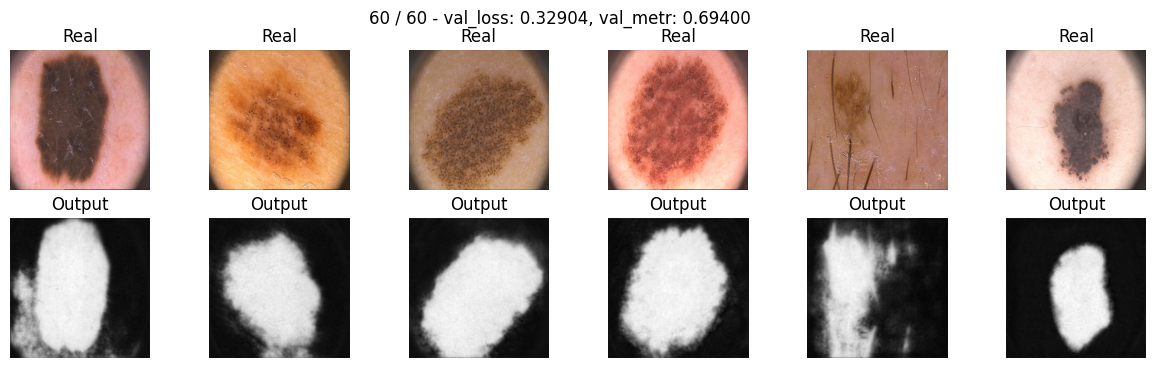

Best val Acc: 0.758000


In [31]:
model_dice = SegNet().to(device)

MAX_EPOCHS = 60
optimaizer = optim.Adam(model_dice.parameters())
res_dice, acc_dice = train(model_dice, optimaizer, dice_loss, MAX_EPOCHS, data_tr, data_val)

VALID:	 0.6939999759197235 
TEST:	 0.5800000131130219


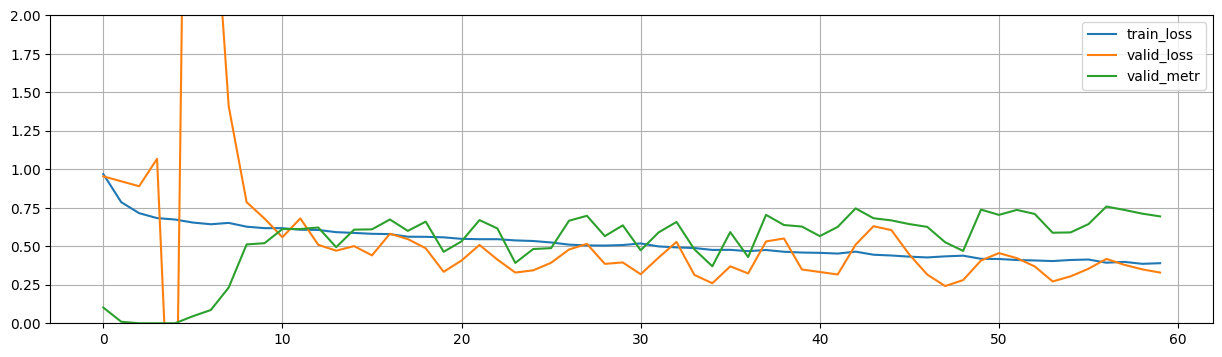

In [32]:
print('VALID:\t', score_model(model_dice, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_dice, iou_pytorch, data_ts))
res, acc = res_dice, acc_dice
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 2))
plt.legend();

### Focal Loss
[Focal loss](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:
$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:
$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.
Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.
$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
Зафиксируем значение $\gamma=2$.

In [33]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    """
    Взвешенный пиксельный вариант Энтропии.
    param eps: параметр, ограничивающий сигмоиду снизу,
    чтобы избежать проблем с логарифмом
    param gamma: характерный параметр
    """
    y_real = torch.unsqueeze(y_real, 1)
    y_pred = torch.clamp(torch.sigmoid(torch.unsqueeze(y_pred, 1)), eps, 1)
    result = ((1 - y_pred) ** gamma) * y_real * torch.log(y_pred) + \
              (1 - y_real) * torch.log(1 - y_pred)
    return -torch.mean(result)         # сделаем mean вместо sum, иначе
                                       # астрономические значения Loss

### SegNet + Focal loss

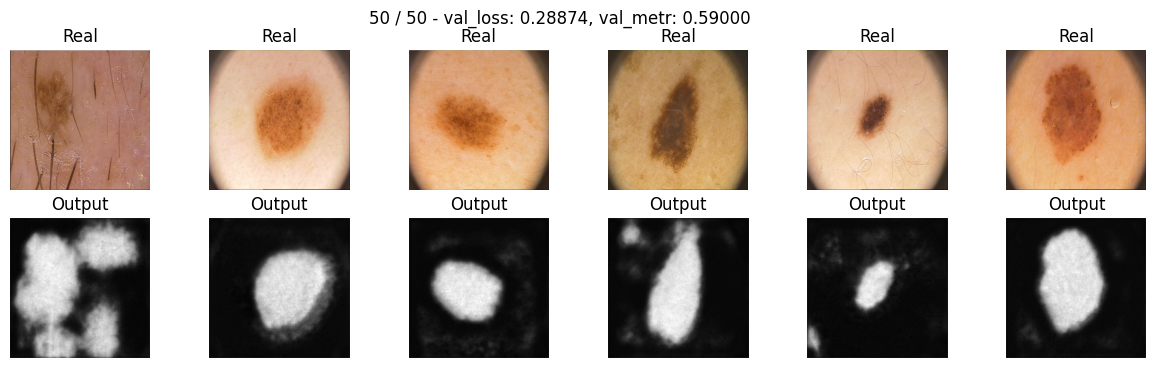

Best val Acc: 0.722000


In [34]:
MAX_EPOCHS = 50
model_focal = SegNet().to(device)
optimaizer = optim.Adam(model_focal.parameters())
res_focal, acc_focal = train(model_focal, optimaizer, focal_loss, MAX_EPOCHS, data_tr, data_val)

In [35]:
print('VALID:\t', score_model(model_focal, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_focal, iou_pytorch, data_ts))
res, acc = res_focal, acc_focal
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
#plt.ylim((0, 2))
plt.legend();

VALID:	 0.5900000035762787 
TEST:	 0.44200000166893005


## Save models and free memory

In [36]:
for model, name in zip((model_bce, model_dice, model_focal), ('bce', 'dice', 'focal')):
    torch.save(model.state_dict(), f'model_{name}.pth')

In [52]:
model_bce, model_dice, model_focal = None, None, None
if is_cuda:
    torch.cuda.empty_cache()
gc.collect()

190

## Мир сегментационных лоссов

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно.
1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

#### Авторы по второй ссылке выложили свой код в дистибутиве
https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py
Если вдруг это будет полезно

In [27]:
model_boundary, model_bl = None, None
softmax_outputs, outputs, inputs, targets = None, None, None, None
if is_cuda:
    torch.cuda.empty_cache()
gc.collect()

0

In [27]:
if is_cuda:
    torch.cuda.empty_cache()
gc.collect()

57710

In [28]:
for inputs, targets in data_tr:
  break

In [29]:
inputs[0]

tensor([[[0.1540, 0.1574, 0.1539,  ..., 0.1338, 0.1449, 0.1173],
         [0.1684, 0.1726, 0.1751,  ..., 0.1379, 0.1540, 0.1381],
         [0.1631, 0.1747, 0.1659,  ..., 0.1467, 0.1676, 0.1424],
         ...,
         [0.1595, 0.1605, 0.1575,  ..., 0.1659, 0.1656, 0.1270],
         [0.1550, 0.1630, 0.1450,  ..., 0.1587, 0.1610, 0.1292],
         [0.1184, 0.1173, 0.1051,  ..., 0.0713, 0.0785, 0.0717]],

        [[0.1464, 0.1490, 0.1356,  ..., 0.1432, 0.1498, 0.1091],
         [0.1486, 0.1531, 0.1481,  ..., 0.1579, 0.1559, 0.1205],
         [0.1420, 0.1613, 0.1472,  ..., 0.1536, 0.1517, 0.1212],
         ...,
         [0.1293, 0.1352, 0.1394,  ..., 0.1551, 0.1487, 0.1137],
         [0.1239, 0.1409, 0.1293,  ..., 0.1600, 0.1550, 0.1213],
         [0.0937, 0.1051, 0.1011,  ..., 0.0796, 0.0810, 0.0656]],

        [[0.1358, 0.1424, 0.1329,  ..., 0.1562, 0.1691, 0.1303],
         [0.1324, 0.1418, 0.1447,  ..., 0.1753, 0.1843, 0.1474],
         [0.1301, 0.1492, 0.1449,  ..., 0.1757, 0.1746, 0.

In [30]:
model_bl = SegNet().to(device)
output = model_bl(inputs.to(device))


In [31]:
output.shape

torch.Size([25, 1, 256, 256])

In [32]:
softmax_outputs = torch.softmax(output, dim=1)

In [33]:
softmax_outputs.shape

torch.Size([25, 1, 256, 256])

In [34]:
softmax_outputs[:, :, :, 1:].shape

torch.Size([25, 1, 256, 255])

In [35]:
softmax_outputs[:, :, :-1, :].shape

torch.Size([25, 1, 255, 256])

In [45]:
import torch
from typing import List, Dict, Any, Tuple
from torch import Tensor

class SurfaceLoss():
    def __init__(self, idc: List[int]):
        self.idc = idc
        print(f"Initialized {self.__class__.__name__} with idc: {idc}")

    def __call__(self, probs: Tensor, dist_maps: Tensor) -> Tensor:
        #assert simplex(probs)  # Предполагается, что это ваша функция для проверки типа данных
        #assert not one_hot(dist_maps)  # Предполагается, что это ваша функция для проверки типа данных

        pc = probs[:, self.idc, ...].type(torch.float32)
        dc = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = torch.einsum("bkwh,bkwh->bkwh", pc, dc)

        loss = multipled.mean()

        return loss

'''def simplex(x: Tensor) -> bool:
    # Ваш код проверки типа данных
    pass

def one_hot(x: Tensor) -> bool:
     #Ваш код проверки типа данных
    pass

# Пример использования
# Предполагается, что у вас есть модель model и данные images, dist_maps
model_output = model(images)
loss_fn = SurfaceLoss(idc=[0, 1])  # Пример выбора классов 0 и 1

loss = loss_fn(model_output, dist_maps)
print("Loss:", loss.item())
'''

'def simplex(x: Tensor) -> bool:\n    # Ваш код проверки типа данных\n    pass\n\ndef one_hot(x: Tensor) -> bool:\n     #Ваш код проверки типа данных\n    pass\n\n# Пример использования\n# Предполагается, что у вас есть модель model и данные images, dist_maps\nmodel_output = model(images)\nloss_fn = SurfaceLoss(idc=[0, 1])  # Пример выбора классов 0 и 1\n\nloss = loss_fn(model_output, dist_maps)\nprint("Loss:", loss.item())\n'

In [46]:
boundary_loss = SurfaceLoss(idc=[0])

Initialized SurfaceLoss with idc: [0]


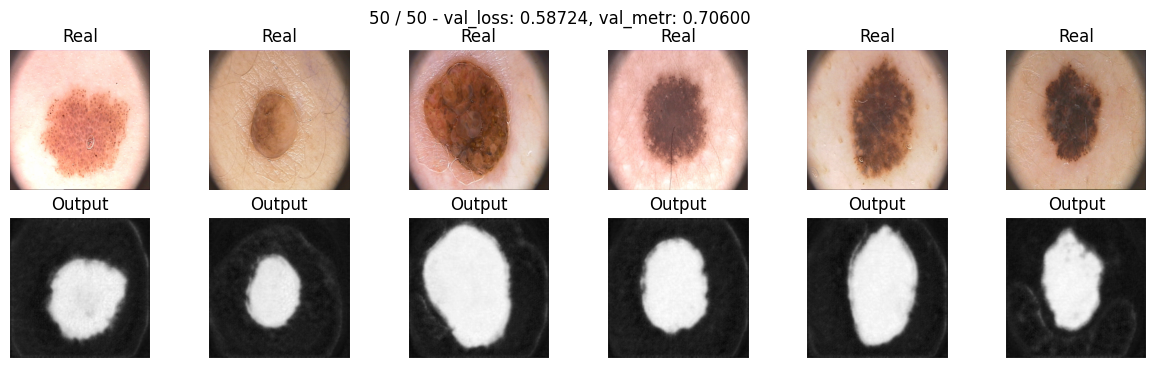

Best val Acc: 0.738000


In [21]:
MAX_EPOCHS = 50
model_boundary = SegNet().to(device)
optimaizer = optim.Adam(model_boundary.parameters())
res_boundary, acc_boudary = train(model_boundary, optimaizer, boundary_loss, MAX_EPOCHS, data_tr, data_val, boundary=True, mix=True,
                                  loss2=focal_loss, alpha=0.5)

VALID:	 0.706000030040741 
TEST:	 0.5699999928474426


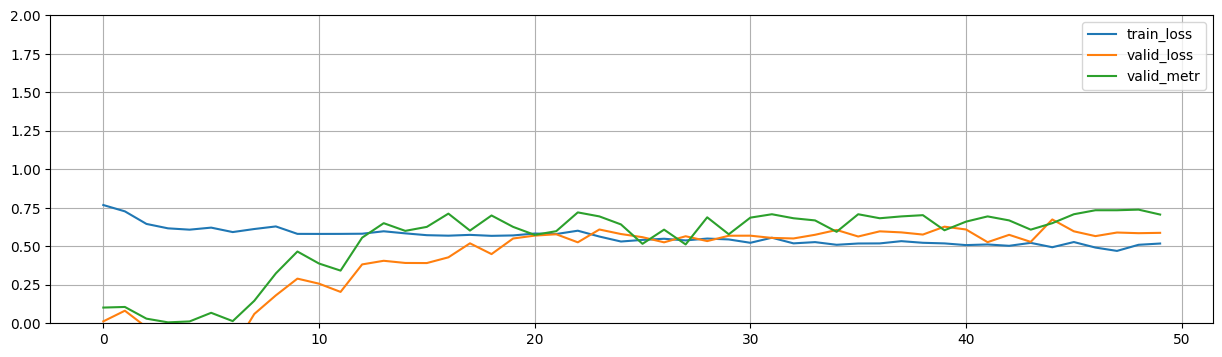

In [22]:
print('VALID:\t', score_model(model_boundary, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_boundary, iou_pytorch, data_ts))
res, acc = res_boundary, acc_boudary
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 2))
plt.legend();

In [23]:
def tversky_loss(y_real, y_pred, alpha=0.3, beta=0.7):
    """
    Tversy Loss realisation.
    param alpha: pre-False-positive constant, default 0.3
    param beta: pre-False-negative constant, default 0.7
    """
    y_pred = nn.Flatten()(y_pred.sigmoid())
    y_real = nn.Flatten()(y_real)

    TP = torch.sum(y_pred * y_real)
    FP = torch.sum((1 - y_real) * y_pred)
    FN = torch.sum(y_real * (1 - y_pred))

    return 1 - TP / ((TP + alpha * FP + beta * FN) or 1)

# протестируем лосс
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r
tversky_loss(y_r, y_p)

tensor(0.4327)

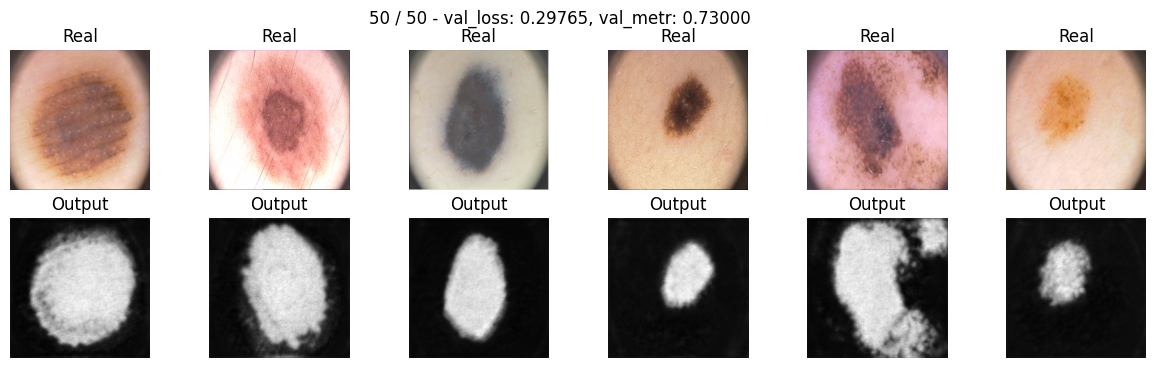

Best val Acc: 0.730000


In [24]:
MAX_EPOCHS = 50
model_tversky = SegNet().to(device)
opt = optim.Adam(model_tversky.parameters())
res_tversky, acc_tversky = train(model_tversky, opt, tversky_loss, MAX_EPOCHS, data_tr, data_val)

VALID:	 0.7299999892711639 
TEST:	 0.5860000252723694


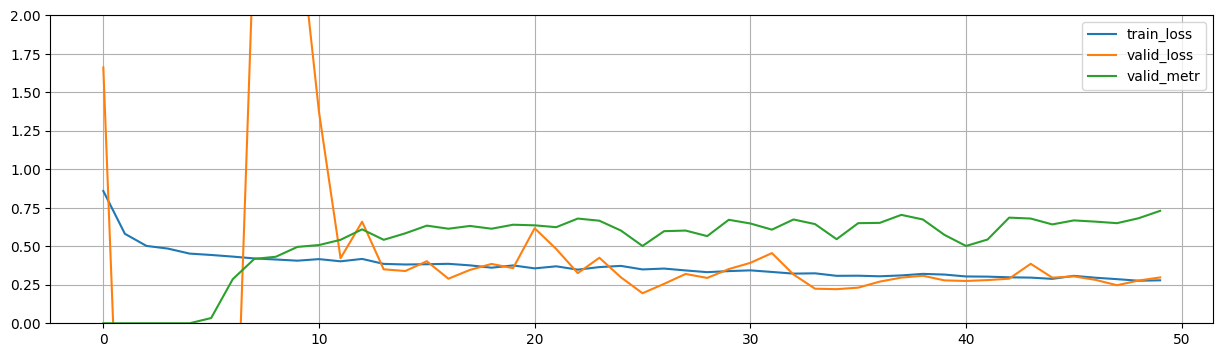

In [25]:
print('VALID:\t', score_model(model_tversky, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_tversky, iou_pytorch, data_ts))
res, acc = res_tversky, acc_tversky
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 2))
plt.legend();

In [38]:
model = model_tversky
name = 'tversky'
torch.save(model.state_dict(), f'model_{name}.pth')
model_tversky = None

with open('results.txt', 'w') as f:
    for res in [res_bce, res_dice, res_focal, res_tversky]:
        f.write(';'.join(map(str, res)) + '\n')

with open('metrics.txt', 'w') as f:
    for acc in [acc_bce, acc_dice, acc_focal, acc_tversky]:
        f.write(';'.join(map(str, acc)) + '\n')

AttributeError: ignored

## U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

![image.png](attachment:7208c877-8f39-4091-b43f-da2bf680f21d.png)

В архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

-----------------------------------------------------------------------------------------



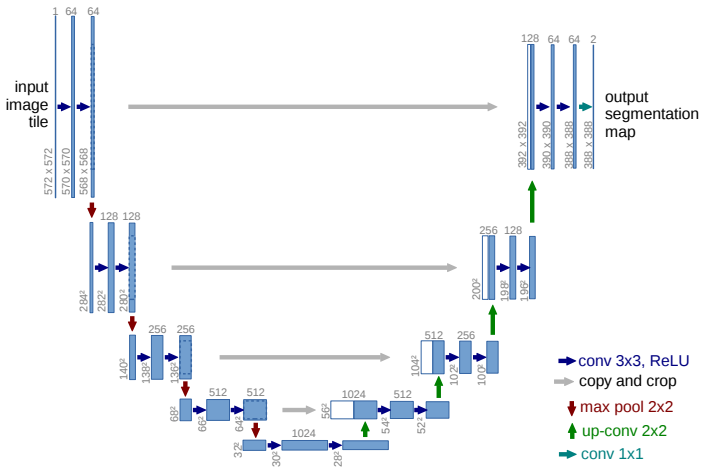

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import gc

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

class OneUnit(nn.Module):
    """
    Блок Conv2D + BatchNorm + Relu
    param ker_size: размер стороны квадратного ядра свёртки, int
    param stride_size: отступ страйда, int
    param pad_size: отступ паддинга, int
    """
    def __init__(self, in_channels, out_channels, ker_size, stride_size, pad_size):
        super(OneUnit, self).__init__()
        self.unit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ker_size,
                      padding=pad_size, stride=stride_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.unit(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512,  1024, 1, 1, 0),
            OneUnit(1024, 1024, 1, 1, 0),
            OneUnit(1024,  512, 1, 1, 0),
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512 * 2, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256 * 2, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128 * 2, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64 * 2, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc00 = self.enc_conv0(inp)
        enc0, idx0 = self.pool0(enc00)
        enc10 = self.enc_conv1(enc0)
        enc1, idx1 = self.pool1(enc10)
        enc20 = self.enc_conv2(enc1)
        enc2, idx2 = self.pool2(enc20)
        enc30 = self.enc_conv3(enc2)
        enc3, idx3 = self.pool3(enc30)

        # bottleneck
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(torch.cat([self.upsample3(neck, idx3), enc30], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec3, idx2), enc20], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec2, idx1), enc10], 1))
        dec0 = self.dec_conv0(torch.cat([self.upsample0(dec1, idx0), enc00], 1))

        # no activation

        return dec0

print('NAME:\tUNet\nPARAMS:\t', sum(len(p) for p in UNet().parameters() if p.requires_grad))

NAME:	UNet
PARAMS:	 29700


In [51]:
if is_cuda:
    torch.cuda.empty_cache()
gc.collect()

MAX_EPOCHS = 60
model_unet = UNet().to(device)
opt = optim.Adam(model_unet.parameters())
res_unet = train(model_unet, opt, bce_loss, MAX_EPOCHS, data_tr, data_val)

* Epoch:	1/60


OutOfMemoryError: ignored

VALID:	 0.6580000221729279 
TEST:	 0.527999997138977


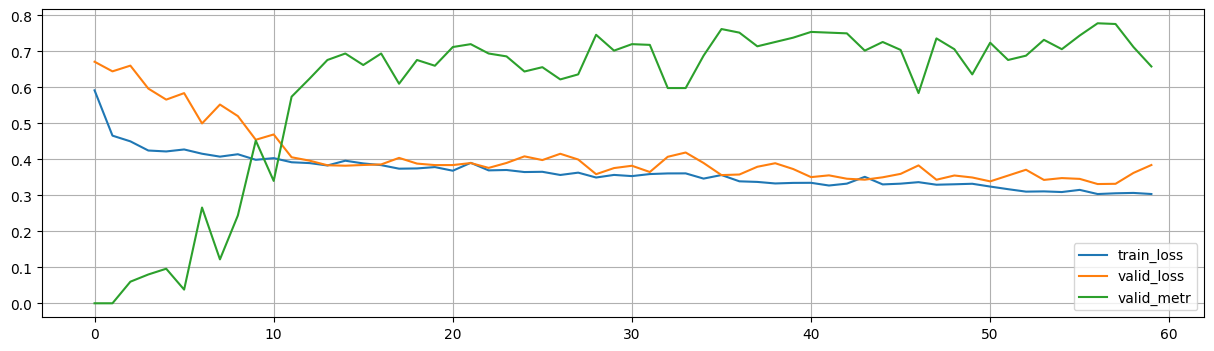

In [43]:
print('VALID:\t', score_model(model_unet, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_unet, iou_pytorch, data_ts))
res, acc = res_unet
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
#plt.ylim((0, 2))
plt.legend();

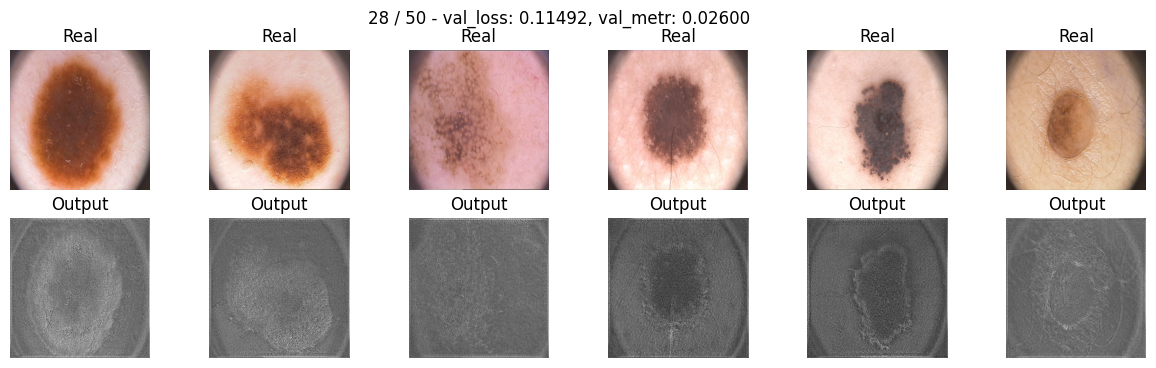

* Epoch:	29/50


KeyboardInterrupt: ignored

In [49]:
MAX_EPOCHS = 50
model_unet_boundary = UNet().to(device)
opt = optim.Adam(model_unet_boundary.parameters())
res_unet_boundary = train(model_unet_boundary, optimaizer, boundary_loss, MAX_EPOCHS, data_tr, data_val,
                          boundary=True, mix=True, loss2=focal_loss, alpha=0.5)

In [ ]:
print('VALID:\t', score_model(model_unet_boundary, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_unet_boundary, iou_pytorch, data_ts))
res, acc = res_unet_boundary
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 2))
plt.legend();

#### Сразу можно отметить гораздо более стабильное обучение и высокий скор
Посмотрим на метрике Тверского

In [ ]:
MAX_EPOCHS = 60
model_unet_tver = UNet().to(device)
opt = optim.Adam(model_unet_tver.parameters())
res_unet_tver = train(model_unet_tver, opt, tversky_loss, MAX_EPOCHS, data_tr, data_val)

In [ ]:
print('VALID:\t', score_model(model_unet_tver, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_unet_tver, iou_pytorch, data_ts))
res, acc = res_unet_tver
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 2))
plt.legend();

VALID:	 0.637999951839447 
TEST:	 0.6880000233650208


## UNet-2
Новая модель -- путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512,  1024, 1, 1, 0),
            OneUnit(1024, 1024, 1, 1, 0),
            OneUnit(1024,  512, 1, 1, 0),
        )

        # decoder (upsampling)

        self.upsample3 = nn.ConvTranspose2d(512, 512,
                            kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512 * 2, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256,
                            kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256 * 2, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128,
                            kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128 * 2, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64,
                            kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64 * 2, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc00 = self.enc_conv0(inp)
        enc0  = self.pool0(enc00)
        enc10 = self.enc_conv1(enc0)
        enc1  = self.pool1(enc10)
        enc20 = self.enc_conv2(enc1)
        enc2  = self.pool2(enc20)
        enc30 = self.enc_conv3(enc2)
        enc3  = self.pool3(enc30)

        # bottleneck
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(torch.cat([self.upsample3(neck,
                                        output_size=enc30.size()), enc30], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec3,
                                        output_size=enc20.size()), enc20], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec2,
                                        output_size=enc10.size()), enc10], 1))
        dec0 = self.dec_conv0(torch.cat([self.upsample0(dec1,
                                        output_size=enc00.size()), enc00], 1))

        # no activation

        return dec0

print('NAME:\tUNet\nPARAMS:\t', sum(len(p) for p in UNet2().parameters() if p.requires_grad))

NAME:	UNet
PARAMS:	 33540


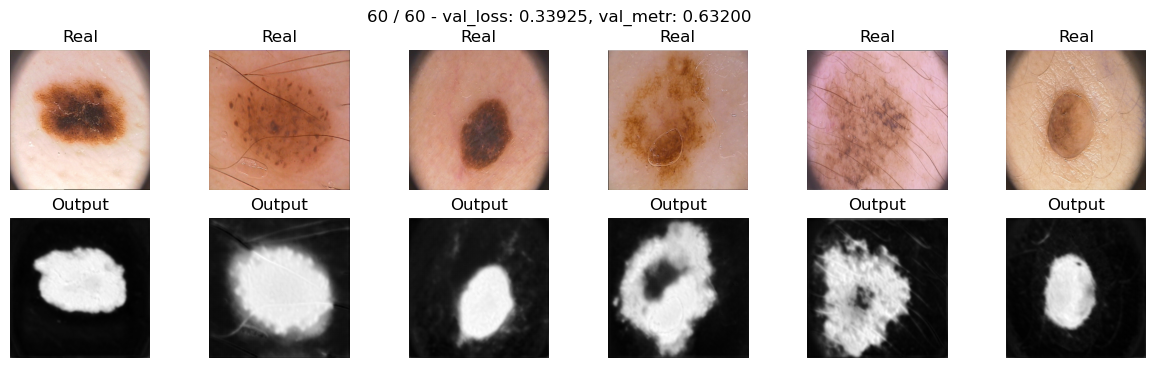

In [ ]:
unet2_model = UNet2().to(device)
opt = optim.Adam(unet2_model.parameters())

MAX_EPOCHS = 60
res_unet2 = train(unet2_model, opt, bce_loss, MAX_EPOCHS, data_tr, data_val)

In [ ]:
print('VALID:\t', score_model(unet2_model, iou_pytorch, data_val),
      '\nTEST:\t', score_model(unet2_model, iou_pytorch, data_ts))
res, acc = res_unet2
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 1))
plt.legend();

VALID:	 0.6319999694824219 
TEST:	 0.6319999992847443


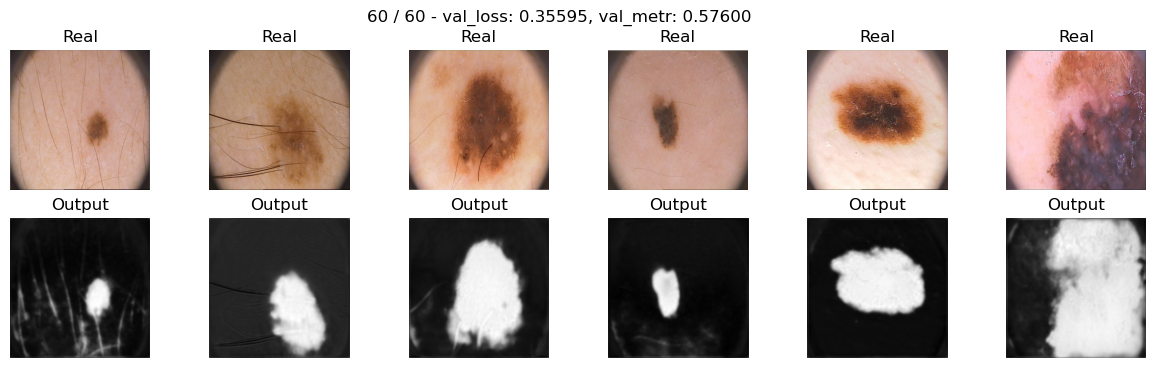

In [ ]:
unet2_model_tver = UNet2().to(device)
opt = optim.Adam(unet2_model_tver.parameters())

MAX_EPOCHS = 60
res_unet2_tver = train(unet2_model_tver, opt, tversky_loss, MAX_EPOCHS, data_tr, data_val)

VALID:	 0.5760000050067902 
TEST:	 0.5799999833106995


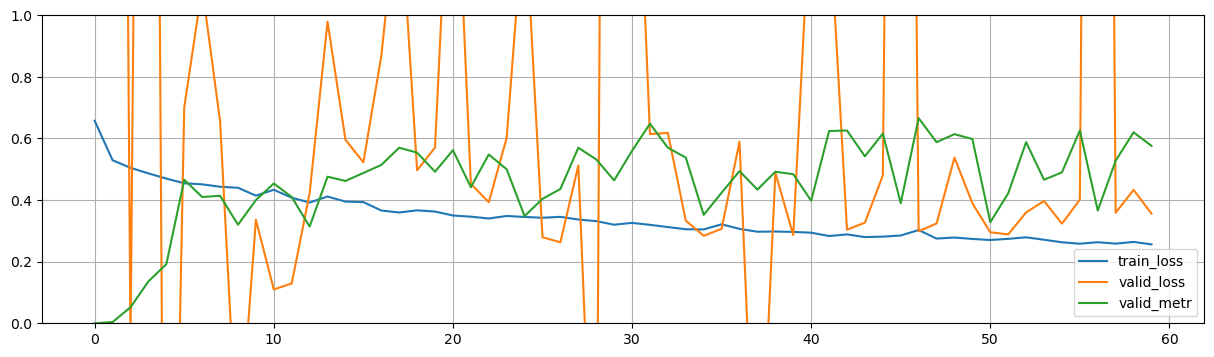

In [ ]:
print('VALID:\t', score_model(unet2_model_tver, iou_pytorch, data_val),
      '\nTEST:\t', score_model(unet2_model_tver, iou_pytorch, data_ts))
res, acc = res_unet2_tver
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.ylim((0, 1))
plt.legend();

## Выводы по работе
Из всех функций Лосса на моих испытаниях с первой моделью SegNet лучше всего показало себя использование dice-loss и tversky-loss. К тому же на них можно позволить себе более длительное обучение, чем на простой бинарной энтропии, показывавшей следы переобучения на 30+ эпохах. Для прочих же loss я брал 60 эпох, при этом можно было и больше.

<br>bce
<br>VALID:	 0.5779999792575836
<br>TEST:	 0.6439999639987946
<br>dice:
<br>VALID:	 0.636000007390976
<br>TEST:	 0.6519999802112579
<br>focal:
<br>VALID:	 0.6059999763965607
<br>TEST:	 0.5999999642372131
<br>tversky
<br>VALID:	 0.6739999949932098
<br>TEST:	 0.699999988079071
<br>
<br>unet-bce
<br>VALID:	 0.6599999666213989
<br>TEST:	 0.7240000069141388
<br>unet-tversky
<br>VALID:	 0.637999951839447
<br>TEST:	 0.6880000233650208
<br>unet2-bce
<br>VALID:	 0.6319999694824219
<br>TEST:	 0.6319999992847443
<br>unet2-tversky
<br>VALID:	 0.5760000050067902
<br>TEST:	 0.5799999833106995

<br> Функция focal_loss не превзошла по результативности простую энтропию для тестовой выборки. Очень интересный опыт работы с tversky-loss, она довольно быстро позволяет выходить SegNet на показатели выше 50-60% и делает обучение более стабильным.
<br> Графики завиимости Losses & metric vs. epoch можно увидеть выше по ходу работы.
<br> Однако, для обеих Unet функция бинарной энтропии показала себя лучше, чем tversky, дав на тесте 0.724

Из сетей лучше всего себя показала Unet с простой бинарной энтропией
<br> Следует отметить, что рассмотренные сети слишком объёмны для рассмотренного датасета (а точнее, датасет слишком мал для такого числа параметров), и обучение слишком подвержено выбросам.
<br> SegNet: 27652 param
<br> UNet: 29700 param
<br> UNet2: 33540 param

Полагаю, что на датасете в десятеро раз большем, все скоры можно было бы сделать выше без риска переобучения.